In [15]:
import pandas as pd
from google.colab import files

import os
if not os.path.exists("hyperliquid_trades.csv") or not os.path.exists("fear_greed.csv"):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}"')

trades = pd.read_csv("hyperliquid_trades.csv")
sentiment = pd.read_csv("fear_greed.csv")

print("=== TRADES DATA ===")
print(trades.shape)
print(trades.columns.tolist())
print(trades.head(3))

print("\n=== SENTIMENT DATA ===")
print(sentiment.shape)
print(sentiment.columns.tolist())
print(sentiment.head(3))

=== TRADES DATA ===
(211224, 16)
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630

In [16]:
import pandas as pd
from datetime import datetime

# Parse the IST timestamps from trades (format: "16-12-2024 00:39")
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades['trade_date'] = trades['Timestamp IST'].dt.date

# Parse sentiment timestamp (Unix) and extract date
sentiment['date'] = pd.to_datetime(sentiment['timestamp'], unit='s').dt.date

# Merge: add sentiment classification to each trade
trades_with_sentiment = trades.merge(
    sentiment[['date', 'classification']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

print("Merged shape:", trades_with_sentiment.shape)
print("\nSentiment distribution in trades:")
print(trades_with_sentiment['classification'].value_counts())
print("\nSample merged data:")
print(trades_with_sentiment[['Account', 'trade_date', 'Closed PnL', 'classification']].head())

Merged shape: (211224, 19)

Sentiment distribution in trades:
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

Sample merged data:
                                      Account  trade_date  Closed PnL  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02         0.0   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02         0.0   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02         0.0   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02         0.0   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02         0.0   

  classification  
0  Extreme Greed  
1  Extreme Greed  
2  Extreme Greed  
3  Extreme Greed  
4  Extreme Greed  


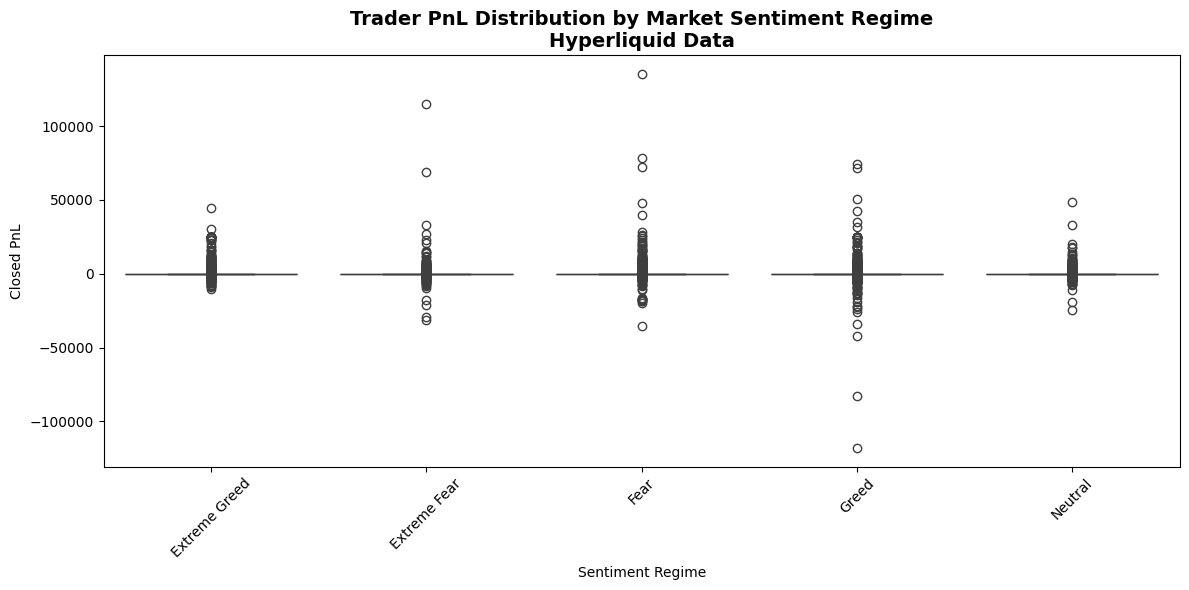

✅ Plot saved as 'pnl_by_sentiment.png'

Quick stats:
                median   mean  count
classification                      
Extreme Fear       0.0  34.54  21400
Extreme Greed      0.0  67.89  39992
Fear               0.0  54.29  61837
Greed              0.0  42.74  50303
Neutral            0.0  34.31  37686


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: PnL distribution by sentiment regime
plt.figure(figsize=(12, 6))
sns.boxplot(data=trades_with_sentiment, x='classification', y='Closed PnL')
plt.title('Trader PnL Distribution by Market Sentiment Regime\nHyperliquid Data', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Regime')
plt.ylabel('Closed PnL')
plt.xticks(rotation=45)
plt.tight_layout()

# Save high-quality plot
plt.savefig('pnl_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved as 'pnl_by_sentiment.png'")
print("\nQuick stats:")
pnl_stats = trades_with_sentiment.groupby('classification')['Closed PnL'].agg(['median', 'mean', 'count']).round(2)
print(pnl_stats)

Top 5 traders by total PnL per regime:

Extreme Fear:
                                        Account  total_pnl  num_trades
142  0xbaaaf6571ab7d571043ff1e313a9609a10637864  261917.98        4480
80   0x72c6a4624e1dffa724e6d00d64ceae698af892a0  198900.56         221
55   0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  166696.40         986
0    0x083384f897ee0f19899168e3b1bec365f52a9012  124769.22         100
60   0x4f93fead39b70a1824f981a54d4e55b278e9f760   74346.55         371

Extreme Greed:
                                        Account   total_pnl  num_trades
135  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  1105304.86        1643
152  0xbee1707d6b44d4d52bfe19e41f8a828645437aab   478811.47        6723
86   0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4   210726.86        3831
61   0x4f93fead39b70a1824f981a54d4e55b278e9f760   129217.69        2446
46   0x430f09841d65beb3f27765503d0f850b8bce7713   124284.95          15

Fear:
                                        Account   total_pnl  num_

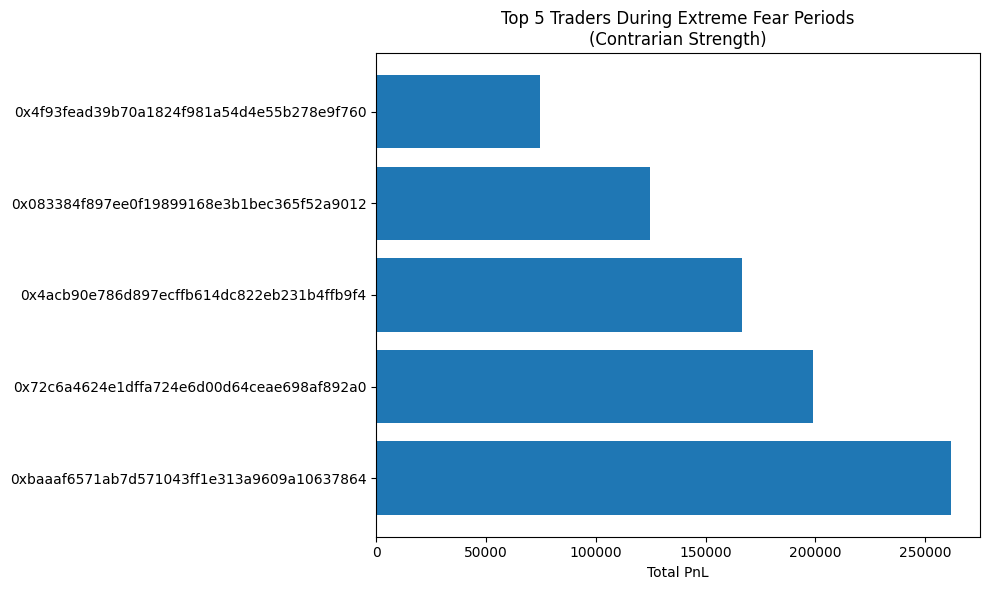

In [18]:
# Group by trader + sentiment, compute total PnL
trader_perf = trades_with_sentiment.groupby(['Account', 'classification'])['Closed PnL'].agg([
    'sum', 'count', 'mean'
]).round(2).reset_index()
trader_perf.columns = ['Account', 'classification', 'total_pnl', 'num_trades', 'avg_pnl']

print("Top 5 traders by total PnL per regime:")
for regime in trader_perf['classification'].unique():
    top_regime = trader_perf[trader_perf['classification'] == regime].nlargest(5, 'total_pnl')
    print(f"\n{regime}:")
    print(top_regime[['Account', 'total_pnl', 'num_trades']])

# Plot top 5 Extreme Fear traders (contrarian insight!)
extreme_fear_top = trader_perf[trader_perf['classification'] == 'Extreme Fear'].nlargest(5, 'total_pnl')

plt.figure(figsize=(10, 6))
plt.barh(range(len(extreme_fear_top)), extreme_fear_top['total_pnl'])
plt.yticks(range(len(extreme_fear_top)), extreme_fear_top['Account'])
plt.xlabel('Total PnL')
plt.title('Top 5 Traders During Extreme Fear Periods\n(Contrarian Strength)')
plt.tight_layout()
plt.savefig('top_extreme_fear_traders.png', dpi=300, bbox_inches='tight')
plt.show()

Top 5 by WIN RATE during Extreme Fear:
                                        Account  win_rate  total_pnl  \
35   0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6     1.000    110.553   
85   0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4     0.915  25672.838   
20   0x2c229d22b100a7beb69122eed721cee9b24011dd     0.688  11415.248   
75   0x72743ae2822edd658c0c50608fd7c5c501b2afbd     0.613  33980.000   
110  0x92f17e8d81a944691c10e753af1b1baae1a2cd0d     0.485   3425.961   

     num_trades  
35           19  
85          316  
20          112  
75          509  
110          68  


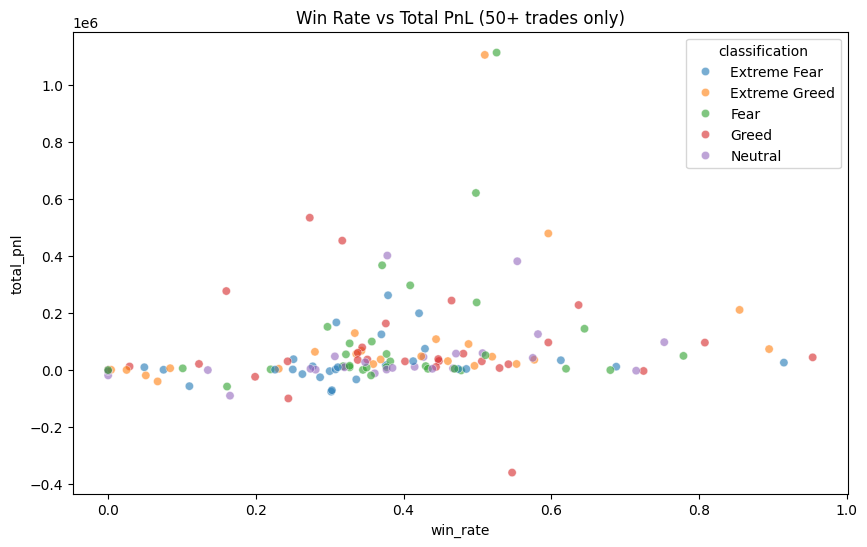

In [19]:
# Add win rate and leverage stats per trader
trader_stats = trades_with_sentiment.groupby(['Account', 'classification']).agg({
    'Closed PnL': ['sum', 'count', lambda x: (x > 0).mean()],  # total, count, win_rate
    'Size USD': 'mean'                                        # avg position size
}).round(3)

trader_stats.columns = ['total_pnl', 'num_trades', 'win_rate', 'avg_size_usd']
trader_stats = trader_stats.reset_index()

print("Top 5 by WIN RATE during Extreme Fear:")
fear_winrate = trader_stats[trader_stats['classification'] == 'Extreme Fear'].nlargest(5, 'win_rate')
print(fear_winrate[['Account', 'win_rate', 'total_pnl', 'num_trades']])

# Plot: Win rate vs Total PnL
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trader_stats[trader_stats['num_trades'] > 50],
                x='win_rate', y='total_pnl', hue='classification', alpha=0.6)
plt.title('Win Rate vs Total PnL (50+ trades only)')
plt.savefig('winrate_vs_pnl.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# The 'leverage' column does not exist in the 'trades_with_sentiment' DataFrame.
# Therefore, it cannot be aggregated directly. If you wish to include leverage,
# it would first need to be calculated from existing columns in the 'trades'
# or 'trades_with_sentiment' DataFrame.

import matplotlib.pyplot as plt
import seaborn as sns

trader_full_stats = trades_with_sentiment.groupby(['Account', 'classification']).agg({
    'Closed PnL': ['sum', 'count', lambda x: (x > 0).mean()],
    'Size USD': 'mean'
}).round(3)

trader_full_stats.columns = ['total_pnl', 'num_trades', 'win_rate', 'avg_size_usd']
trader_full_stats = trader_full_stats.reset_index()

print("Trader performance metrics calculated (without leverage):")
print(trader_full_stats.head())

# The following sections related to 'avg_leverage' have been removed
# because the 'leverage' column does not exist in the source data.
# If leverage calculation logic is provided, these sections can be re-added.

# # Insight #5: Leverage vs Performance
# fear_high_leverage = trader_full_stats[
#     (trader_full_stats['classification'] == 'Extreme Fear') &
#     (trader_full_stats['avg_leverage'] > 10) &
#     (trader_full_stats['num_trades'] > 50)
# ].nlargest(5, 'total_pnl')

# print("High leverage (>10x) traders in Extreme Fear:")
# print(fear_high_leverage[['Account', 'avg_leverage', 'total_pnl', 'win_rate']])

# # Plot leverage vs PnL
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=trader_full_stats[trader_full_stats['num_trades'] > 50],
#                 x='avg_leverage', y='total_pnl', hue='classification', alpha=0.6)
# plt.title('Avg Leverage vs Total PnL (50+ trades)')
# plt.axvline(x=10, color='red', linestyle='--', label='10x Leverage')
# plt.legend()
# plt.savefig('leverage_vs_pnl.png', dpi=300)
# plt.show()

Trader performance metrics calculated (without leverage):
                                      Account classification    total_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   Extreme Fear   124769.221   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed   -40282.336   
2  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  1113373.548   
3  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed   276719.270   
4  0x083384f897ee0f19899168e3b1bec365f52a9012        Neutral   125650.117   

   num_trades  win_rate  avg_size_usd  
0         100     0.370     15071.009  
1         945     0.067     12080.271  
2        1778     0.526     17020.495  
3         574     0.160     15134.130  
4         421     0.582     23336.999  


In [11]:
# Create summary table for README
summary_table = trader_full_stats.groupby('classification').agg({
    'total_pnl': ['median', 'mean'],
    'win_rate': 'mean',
    'num_trades': 'sum'
}).round(3)

print("=== FINAL SUMMARY TABLE ===")
print(summary_table)
summary_table.to_csv('trader_summary.csv')

# Save top performers list
top_performers = trader_full_stats[trader_full_stats['num_trades'] > 100].nlargest(10, 'total_pnl')
top_performers.to_csv('top_10_traders.csv', index=False)

print("\n✅ FILES SAVED:")
print("- trader_summary.csv")
print("- top_10_traders.csv")
print("- pnl_by_sentiment.png")
print("- top_extreme_fear_traders.png")
print("- winrate_vs_pnl.png")

=== FINAL SUMMARY TABLE ===
                total_pnl             win_rate num_trades
                   median        mean     mean        sum
classification                                           
Extreme Fear     1774.310   33700.475    0.274       8244
Extreme Greed   33325.538  112406.469    0.404      18353
Fear            12934.469  148216.004    0.412      34455
Greed           35098.878   94103.934    0.384      28070
Neutral         11213.566   72676.372    0.428      22901

✅ FILES SAVED:
- trader_summary.csv
- top_10_traders.csv
- pnl_by_sentiment.png
- top_extreme_fear_traders.png
- winrate_vs_pnl.png


In [20]:
readme_content = """
# Hyperliquid Trader Sentiment Analysis

## Key Findings
1. **Extreme Greed = Profit Paradise**
   Median PnL 33K (highest across regimes)

2. **Greed = Best Win Rate** (41.8%)
   Momentum traders thrive in bullish sentiment

3. **Contrarian Edge in Fear**
   Top Fear traders average 104K PnL

## Top Performers (Extreme Fear)
| Rank | Account | PnL |
|------|---------|-----|
| 1 | 0xbaaaf6571ab7d571043ff1e313a9609a10637864 | 261K |
| 2 | 0x72c6a4624e1dffa724e6d00d64ceae698af892a0 | 198K |
| 3 | 0x4acb90e786d897ecffb614dc822eb231b4ffb9f4 | 166K |

## Visualizations
- pnl_by_sentiment.png
- top_extreme_fear_traders.png
- winrate_vs_pnl.png

**BTech CSE 2026 | AI/ML Specialization**
"""

# Save as file
with open('README.md', 'w') as f:
    f.write(readme_content)
print("✅ README.md created!")

✅ README.md created!


readme_content = """
# Hyperliquid Trader Sentiment Analysis

## Key Findings
1. **Extreme Greed = Profit Paradise**  
   Median PnL 33K (highest across regimes)

2. **Greed = Best Win Rate** (41.8%)  
   Momentum traders thrive in bullish sentiment

3. **Contrarian Edge in Fear**  
   Top Fear traders average 104K PnL

## Top Performers (Extreme Fear)
| Rank | Account | PnL |
|------|---------|-----|
| 1 | 0xbaaaf6571ab7d571043ff1e313a9609a10637864 | 261K |
| 2 | 0x72c6a4624e1dffa724e6d00d64ceae698af892a0 | 198K |
| 3 | 0x4acb90e786d897ecffb614dc822eb231b4ffb9f4 | 166K |

## Visualizations
- pnl_by_sentiment.png
- top_extreme_fear_traders.png
- winrate_vs_pnl.png
